### Quench dynamics with Emu-SV

In this tutorial, we will explore how to simulate a quench sequence using EMU-SV as the backend for Pulser. EMU-SV is a state vector emulator tailored for efficiently simulating the dynamics of the Rydberg Hamiltonian, offering both speed and precision for quantum system simulations.

Our primary objective will be to study the evolution of the $\sigma _z$ operator. However, we will utilize the number operator $n_i$, also referred to as the qubit occupation operator, for practical calculations. By carefully adjusting the detuning, we can account for and effectively compensate for additional terms in the Hamiltonian, simplifying the analysis.

This tutorial will take you step by step through the process of setting up the simulation, running it with EMU-SV, and interpreting the results to better understand the system's behavior during the quench sequence.


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import replace

#pulser imports
from pulser.devices import AnalogDevice
from pulser import Sequence, Register, Pulse
from pulser.channels import Rydberg

#emulators imports
import emu_sv

In [6]:
# define the register arregement function and the device for the quench
def chain_coordinates(N,R1,R2):
    """Generate the coordinates of a chain of points arranged in two parallel 
    lines."""
    coords = [(-R2/2,i*R1-(N-1)/2*R1) for i in range(N)]
    coords = coords + [(R2/2,i*R1-(N-1)/2*R1) for i in range(N)]
    return coords


# device settings
VD = AnalogDevice.to_virtual()
VD = replace(
    VD, 
    max_atom_num=50,
    max_radial_distance=38,
    max_sequence_duration=None,
    channel_objects=(
        Rydberg.Global(48.69468613064179, 12.566370614359172),
    ))

The registers will be arranged in two parallel lines, each containing $N$ atoms, as generated by the function `chain_coordinates`. The atoms will be vertically separated by $R_1$ and horizontally by $R_2$ . The $U_i$ terms represent the interaction energies between pairs of atoms at various distances. For instance,  $U_1$ represents the interaction energy between nearest neighbors along the same line, separated by a distance $R_1$. $U_2$ is the interaction energy between atoms across the two parallel lines, separated by the horizontal distance $R_2$, and so on.

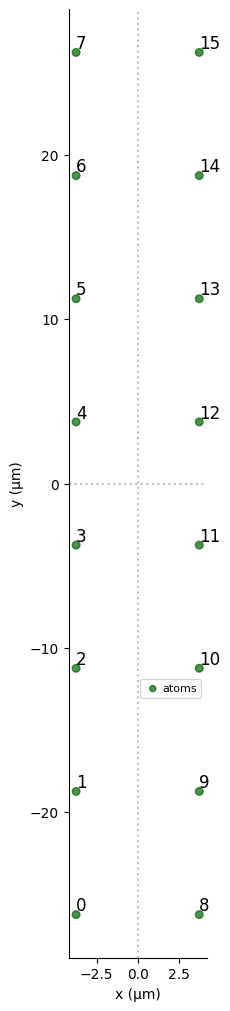

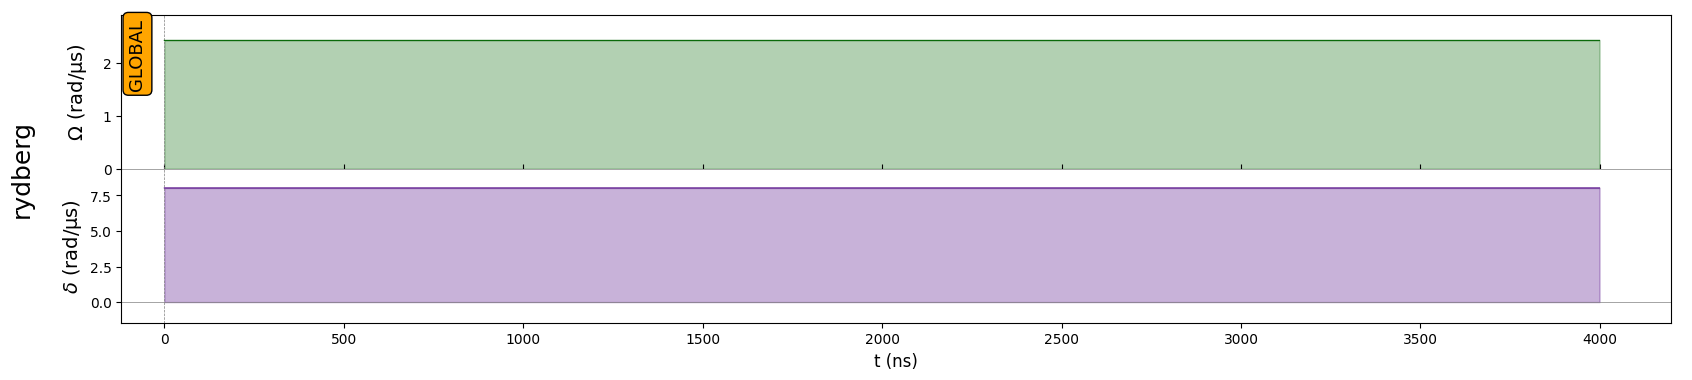

In [7]:
# Parameters for the system
N  = 8 # number of atoms in a line
R1 = 7.5 # vertical distance between atoms in a single chain
lam = 1
R2 = R1/(lam**(1/6)) # # Horizontal distance between the two parallel chains of atoms

U1 = VD.interaction_coeff/R1**6 #interaction with nearest neighbors in the same line
U2 = VD.interaction_coeff/R2**6 #interacion between atoms across two paralell lines
U3 = VD.interaction_coeff/(np.sqrt(R1**2+R2**2))**6 # interaction between diagonal neighbors
U4 = VD.interaction_coeff/(2*R1)**6 # second-nearest neighbors interaction in the same line
U5 = VD.interaction_coeff/(np.sqrt(4*R1**2+R2**2))**6 # second-nearest interaction across lines

coords_exact = chain_coordinates(N,R1,R2) # generate the coordinates of the atoms

hx = 1 
hz = 0 

t = 4000 # duration of the sequence
dt = 10 # time step

NN_coeff = U1/4
omega = 2*hx*NN_coeff
delta = (-2*hz*NN_coeff+U1+U2/2+U3+U4+U5) #compensate the interaction shift
T = t/1000*NN_coeff
dT = dt/1000*NN_coeff


# pulser register
qubits = dict(enumerate(coords_exact))
reg0 = Register(qubits)
reg0.draw()

#pulser sequence
seq = Sequence(reg0, VD)
seq.declare_channel("rydberg", "rydberg_global")
simple_pulse = Pulse.ConstantPulse(t, omega, delta, 0)
seq.add(simple_pulse, "rydberg")
seq.draw()


#### SVBackend, SVConfig and operators 

In order to run a sequence, you need to instanciate *SVBackend* and *SVConfig*. This goes in a similar way of __EMU_MPS__. 

In [8]:


basis = ("r","g",)
eval_times = [x/t for x in range(dt, t, 4*dt)]  # must be from 0 to 1
occupation = emu_sv.Occupation(evaluation_times=eval_times, one_state=basis) 

#emu-sv config
svconfig = emu_sv.SVConfig(dt=dt,observables=[occupation]) # gpu = True
#svconfig = emu_sv.SVConfig(gpu=True,dt=dt,observables=[density]) 

# emu-sv backendsd
sim = emu_sv.SVBackend(seq, config=svconfig)
results = sim.run()

step = 1/400, RSS = 336560.128 MB, Δt = 0.026 s
step = 2/400, RSS = 352452.608 MB, Δt = 0.029 s
step = 3/400, RSS = 362987.520 MB, Δt = 0.028 s
step = 4/400, RSS = 367230.976 MB, Δt = 0.025 s
step = 5/400, RSS = 376717.312 MB, Δt = 0.027 s
step = 6/400, RSS = 376750.080 MB, Δt = 0.024 s
step = 7/400, RSS = 382042.112 MB, Δt = 0.026 s
step = 8/400, RSS = 388399.104 MB, Δt = 0.025 s
step = 9/400, RSS = 390512.640 MB, Δt = 0.027 s
step = 10/400, RSS = 390512.640 MB, Δt = 0.026 s
step = 11/400, RSS = 390512.640 MB, Δt = 0.026 s
step = 12/400, RSS = 390512.640 MB, Δt = 0.026 s
step = 13/400, RSS = 395804.672 MB, Δt = 0.027 s
step = 14/400, RSS = 397918.208 MB, Δt = 0.025 s
step = 15/400, RSS = 397934.592 MB, Δt = 0.027 s
step = 16/400, RSS = 400064.512 MB, Δt = 0.027 s
step = 17/400, RSS = 400064.512 MB, Δt = 0.027 s
step = 18/400, RSS = 403243.008 MB, Δt = 0.026 s
step = 19/400, RSS = 403243.008 MB, Δt = 0.025 s
step = 20/400, RSS = 403243.008 MB, Δt = 0.024 s
step = 21/400, RSS = 405356.5

### Plot the evolution of the occupation $n_i$ of all the atoms

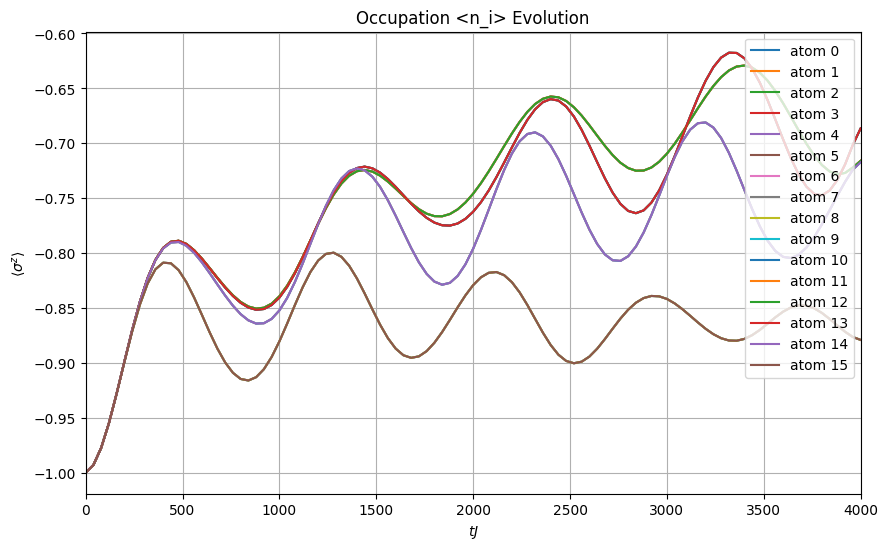

In [41]:
occupation_values = np.array(results.occupation)
times = np.arange(0,t+dt,4*dt)

plt.figure(figsize=(10, 6)) 

for i in range(2*N):
    result_plot = occupation_values[:,i]
    plt.plot(times,2*result_plot-1,label=f'atom {i}')

plt.title('Occupation <n_i> Evolution')
plt.xlim(0,t)

plt.xlabel(r'$tJ$')
plt.ylabel(r'$\langle \sigma^z \rangle$')
plt.grid()

plt.legend(loc='upper right')
plt.show()